# 1-bit Deutsch-Jozsa (XOR)

## Imports and Setup

In [1]:
from parse_circuit import parse_circuit


In [2]:
import os
import warnings
from os import path
import random
# Suppress warnings for cleaner outputs
warnings.filterwarnings("ignore")

# Path to data directory
DATA_PATH = "./grape"

# Set the working directory
os.chdir(DATA_PATH)

import grape  # Grammatical evolution library

# Path to grammar file
GRAMMAR_FILE = "xor.bnf"
BNF_GRAMMAR_PATH = path.join("grammars", GRAMMAR_FILE)
BNF_GRAMMAR = grape.Grammar(BNF_GRAMMAR_PATH)
import algorithms  # Evolutionary algorithms

In [3]:
from qiskit import QuantumCircuit, transpile  
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram 
import numpy as np
import grape
# import algorithms
import matplotlib.pyplot as plt
from IPython.display import display
from deap import creator, base, tools
import math
import pandas as pd
import re
from typing import Any, Tuple

## Grammatical Evolution

### Fitness function

In [4]:
# 1) DEFINE THE FOUR POSSIBLE ORACLES FOR 1-BIT DEUTSCH–JOZSA
#    (We’ll implement them as functions that apply the oracle to a circuit)
# ------------------------------------------------------------------------
def apply_oracle_constant0(qc):
    """
    f(x)=0 for both x=0,1.
    Does nothing to the circuit's qubits.
    """
    pass
def apply_oracle_constant1(qc):
    """
    f(x)=1 for both x=0,1.
    We flip the ancilla (qubit 1) unconditionally:
    This effectively implements 'x' on qubit 1.
    """
    qc.x(1)

def apply_oracle_balanced0to1(qc):
    """
    f(x)=x. For 1 data qubit (qubit 0) and ancilla (qubit 1),
    this is XOR: flip qubit 1 if qubit 0 is 1.
    """
    qc.cx(0,1)

def apply_oracle_balanced1to0(qc):
    """
    f(x)= NOT x. Another balanced function: flips ancilla if data qubit is 0.
    Implementation: toggle qubit 0, then do XOR, then toggle qubit 0 again.
    """
    # Toggle data qubit so 0->1, 1->0
    qc.x(0)
    # Now ancilla flips iff data was originally 0
    qc.cx(0, 1)
    # Toggle data back
    qc.x(0)

In [5]:
# List them for easy iteration:
ORACLES = {
    "constant0": apply_oracle_constant0,
    "constant1": apply_oracle_constant1,
    "balanced0to1": apply_oracle_balanced0to1,
    "balanced1to0": apply_oracle_balanced1to0
}

In [6]:
# ------------------------------------------------------------------------
# 2) HELPER: SIMULATE A CIRCUIT AND RETURN PROBABILITIES
# ------------------------------------------------------------------------
def get_measurement_probabilities(qc, shots=1024):
    """
    Execute the given QuantumCircuit on a local QasmSimulator,
    return a dictionary of counts normalized by shots.
    """
    simulator = QasmSimulator()
    job = simulator.run(qc, backend=simulator, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Convert raw counts -> probabilities
    probs = {}
    for outcome, count in counts.items():
        probs[outcome] = count / shots
    return probs


In [7]:
# ------------------------------------------------------------------------
# 3) CLASSIFY OUTCOME AS "CONSTANT" OR "BALANCED"
#    For 1-qubit Deutsch–Jozsa, we typically look at measurement of qubit 0.
#    - If qubit 0 is measured 0 with high probability -> 'constant'
#    - If qubit 0 is measured 1 with high probability -> 'balanced'
# ------------------------------------------------------------------------
def classify_circuit(probabilities, threshold=0.48):
    """
    - Sum up probabilities of outcomes where qubit0=0 vs qubit0=1.
    - If P(qubit0=0) >= threshold, classify as 'constant', else 'balanced'.
    """
    p_qubit0_is_0 = 0.0
    p_qubit0_is_1 = 0.0
    for outcome, p in probabilities.items():
        # outcome is e.g. '00' or '11' (qubit0 is the leftmost bit in Qiskit)
        # *BUT*: By default, Qiskit labels the rightmost bit as qubit0.
        # If you're measuring qubit 0 into classical bit 0, the outcome string might be reversed.
        # We can handle that carefully, but let's assume the outcome string is [qubit1, qubit0].
        #
        # If your circuit measures (0->0), (1->1), Qiskit outcome "xy" has x for qubit1, y for qubit0.
        #
        # So qubit0 is the RIGHT character of the 2-bit string.
        # We'll check that one.
        if outcome[1] == '0':
            p_qubit0_is_0 += p
        else:
            p_qubit0_is_1 += p

    if p_qubit0_is_0 >= threshold:
        return "constant"
    else:
        return "balanced"

In [8]:
# ------------------------------------------------------------------------
# 4) DETERMINE IF THE CIRCUIT CORRECTLY CLASSIFIES A GIVEN ORACLE
# ------------------------------------------------------------------------
def is_correct_classification(oracle_name, circuit_classification):
    """
    Map the oracle type -> correct classification, then compare with circuit classification.
    """
    if oracle_name.startswith("constant"):
        correct = "constant"
    else:
        correct = "balanced"
    return (circuit_classification == correct)


In [9]:
# ------------------------------------------------------------------------
# 5) EVALUATE FITNESS:
#    "Number of Misses" + "Max Probability of Error"
#    Lower is better.
# ------------------------------------------------------------------------
def evaluate_fitness(individual_code, threshold=0.48):
    """
    1) Parse the individual's code into a QuantumCircuit using parse_circuit
    2) For each of the four oracles, clone that base circuit, apply the oracle,
       then measure and classify.
    3) Fitness = num_misses + max_probability_of_error
    """
    # We'll keep track of these across all oracles:
    num_misses = 0
    max_prob_of_error = 0.0
    
    # First, parse the individual's code ONCE to get the "base" circuit
    # (the grammar presumably has placeholders for the Oracle, but let's
    #  treat the result as just a "pre-oracle" circuit.)
    try:
        base_qc = parse_circuit(individual_code) 
    except ValueError as ve:
        print("Error parsing circuit:", ve)
        # If parsing fails, return a large penalty
        return float('inf')
    
    # For each oracle, we'll *copy* base_qc, apply the oracle, then simulate
    for oracle_name, oracle_fn in ORACLES.items():
        # Clone the "base" circuit to avoid altering it across oracles
        qc_test = base_qc.copy()  # or base_qc.deepcopy() in some Qiskit versions

        # Apply the actual oracle
        oracle_fn(qc_test)

        # Simulate
        probs = get_measurement_probabilities(qc_test, shots=1024)

        # Classify
        predicted = classify_circuit(probs, threshold=threshold)
        correct = is_correct_classification(oracle_name, predicted)
        if not correct:
            num_misses += 1

        # Probability of error: 
        # For a "constant" oracle, error = P(q0=1). For a "balanced" oracle, error = P(q0=0).
        p_q0_0 = sum(probs[o] for o in probs if o[1] == '0')
        p_q0_1 = 1.0 - p_q0_0
        if oracle_name.startswith("constant"):
            error_prob = p_q0_1
        else:
            error_prob = p_q0_0
        if error_prob > max_prob_of_error:
            max_prob_of_error = error_prob

    # Combine: fitness = (# misses) + (max probability of error)
    fitness = num_misses + max_prob_of_error
    return fitness


### Decode Individual

In [10]:
def decode_individual(ind):
    """
    Decodes the individual's genome into a phenotype code string.
    Returns:
        A string containing the code if decoding is successful,
        or None if invalid.
    """
    if ind.invalid or not hasattr(ind, 'phenotype'):
        return None

    try:
        # Ensure the phenotype is a single string.
        phenotype_code = ind.phenotype
        if isinstance(phenotype_code, list):
            phenotype_code = "".join(phenotype_code)

        # Clean the phenotype using regex.
        cleaned_code = re.sub(r'\\n', '\n', phenotype_code)  # Replace literal \n with newlines
        cleaned_code = re.sub(r'^"|"$', '', cleaned_code)       # Remove leading/trailing quotes
        cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)      # Replace isolated quotes with newlines

        return cleaned_code
    except Exception as ex:
        print(f"[Decode Error] {ex}")
        return None

## GE Initialization

In [11]:
# Define GE parameters
POPULATION_SIZE    = 1000
MAX_GENERATIONS    = 100
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.1
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 7
MIN_INIT_DEPTH     = 9        
MAX_INIT_DEPTH     = 20       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION='list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [12]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)


In [13]:
def evaluate(individual: Any, points_train=None) -> Tuple[float]:
    """
    Evaluate an individual by decoding its phenotype (a code string) into a quantum circuit
    and computing its fitness by testing its performance across all possible marked states.
    
    If decoding fails, returns (infinity,).
    """
    try:
        # decode_individual should return the phenotype string.
        phenotype_str = decode_individual(individual)
    except Exception as e:
        print(f"[Decoding Error] {e}")
        return (float('inf'),)
    
    if not phenotype_str:
        return (float('inf'),)
    
    fitness_val = evaluate_fitness(phenotype_str)
    return (fitness_val,)
toolbox.register("evaluate", evaluate)


In [14]:
population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_DEPTH,
                                      max_init_depth=MAX_INIT_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                       )
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GE evolutionary algorithm with elitism
population, logbook = algorithms.ge_eaSimpleWithElitism(
    population,
    toolbox,
    cxpb=P_CROSSOVER,
    mutpb=P_MUTATION,
    ngen=MAX_GENERATIONS,
    elite_size=ELITE_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    codon_size=CODON_SIZE,
    max_tree_depth=MAX_TREE_DEPTH,
    max_genome_length=None,
    codon_consumption=CODON_CONSUMPTION,
    report_items=["gen", "min", "max", "avg", "std"],
    genome_representation="list",
    stats=stats,
    halloffame=hof,
    verbose=False
)

gen = 0 , Best fitness = (0.4765625,)
gen = 1 , Best fitness = (0.4765625,) , Number of invalids = 120
gen = 2 , Best fitness = (0.4765625,) , Number of invalids = 106
gen = 3 , Best fitness = (0.4765625,) , Number of invalids = 60
gen = 4 , Best fitness = (0.4765625,) , Number of invalids = 54
gen = 5 , Best fitness = (0.4765625,) , Number of invalids = 44
gen = 6 , Best fitness = (0.4765625,) , Number of invalids = 37
gen = 7 , Best fitness = (0.4765625,) , Number of invalids = 28
gen = 8 , Best fitness = (0.4765625,) , Number of invalids = 37
gen = 9 , Best fitness = (0.4765625,) , Number of invalids = 18
gen = 10 , Best fitness = (0.4765625,) , Number of invalids = 22
gen = 11 , Best fitness = (0.4765625,) , Number of invalids = 33
gen = 12 , Best fitness = (0.4765625,) , Number of invalids = 30
gen = 13 , Best fitness = (0.4765625,) , Number of invalids = 29
gen = 14 , Best fitness = (0.4765625,) , Number of invalids = 26
gen = 15 , Best fitness = (0.4765625,) , Number of invalids

In [15]:
def code_to_circuit(phenotype_code):
    """
    Executes the phenotype code (a string) to create a QuantumCircuit.
    Returns the circuit (assumed to be stored in the variable 'qc') if successful,
    or None otherwise.
    """
    local_vars = {}
    try:
        exec(phenotype_code, globals(), local_vars)
        if "qc" in local_vars:
            return local_vars["qc"]
        else:
            print("No circuit variable 'qc' found in phenotype code.")
            return None
    except Exception as e:
        print(f"Error executing phenotype code: {e}")
        return None


[HALL OF FAME]
Individual 1:
Genome: [353, 376, 166, 280, 398, 204, 171, 121, 378, 32, 217, 271]
Phenotype: "qc = QuantumCircuit(2, 2)\n" "## Initialize circuit\n" "qc.x(1)\n" "## Apply Hadamard on qubits 0 and 1\n" "qc.h(0)\n" "qc.h(1)\n" "## Begin Oracle\n" "qc.cz(" "0,1" ")\n" "qc.x(" "1" ")\n" "## End Oracle\n" "## Apply final Hadamard on qubit 0 only\n" "qc.h(0)\n" "## Measure both qubits\n" "qc.measure(0,0)\n" "qc.measure(1,1)\n"
Fitness: 0.4765625


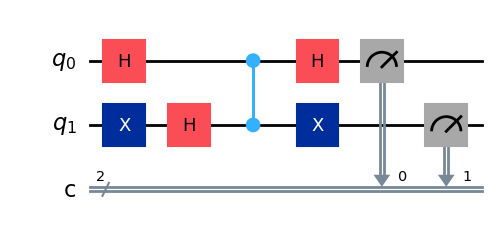


Best Individual's Fitness: 0.4765625


In [16]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

# Decode and display the best circuit from the Hall of Fame
best_ind = hof.items[0]
best_phenotype = decode_individual(best_ind)
best_circuit = code_to_circuit(best_phenotype)

if best_circuit:
    display(best_circuit.draw("mpl"))  # Display the circuit diagram
else:
    print("The best individual could not be decoded into a valid circuit.")

print("\nBest Individual's Fitness:", best_ind.fitness.values[0])

In [17]:
# max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
# min_fitness_values, std_fitness_values = logbook.select("min", "std")
# fitness_test = logbook.select("fitness_test")

# best_ind_length = logbook.select("best_ind_length")
# avg_length = logbook.select("avg_length")

# selection_time = logbook.select("selection_time")
# generation_time = logbook.select("generation_time")
# gen, invalid = logbook.select("gen", "invalid")
# avg_used_codons = logbook.select("avg_used_codons")
# best_ind_used_codons = logbook.select("best_ind_used_codons")

# best_ind_nodes = logbook.select("best_ind_nodes")
# avg_nodes = logbook.select("avg_nodes")

# avg_depth = logbook.select("avg_depth")

# header = REPORT_ITEMS

# results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
#                                 min_fitness_values, max_fitness_values, fitness_test,
#                                 best_ind_length, avg_length,
#                                 best_ind_nodes, avg_nodes,
#                                 avg_depth,
#                                 avg_used_codons, best_ind_used_codons,
#                                 selection_time, generation_time)),
#                columns = header)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 10000)
# pd.set_option('display.colheader_justify', 'center')

# display(results)

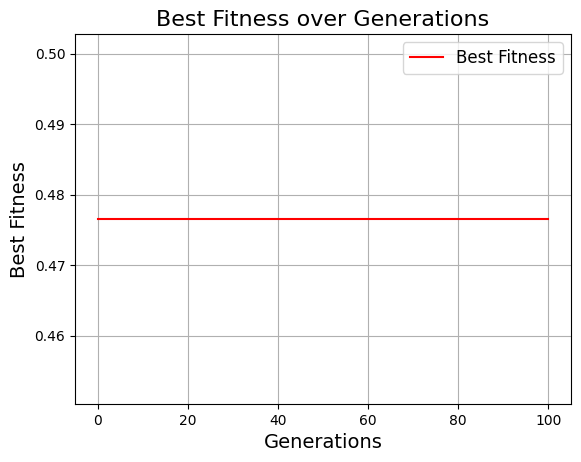

In [18]:
# Extract generations and minimum fitness values
generations = logbook.select("gen")
min_fitness_values = logbook.select("min")

# Plot best fitness over generations
plt.plot(generations, min_fitness_values, color='red', label="Best Fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.grid(True)
plt.show()

In [19]:
oracles = {
    "constant0": apply_oracle_constant0,
    "constant1": apply_oracle_constant1,
    "balanced0to1": apply_oracle_balanced0to1,
    "balanced1to0": apply_oracle_balanced1to0
}

best_phenotype = decode_individual(best_ind)
best_circuit_base = code_to_circuit(best_phenotype)

if best_circuit_base is not None:
    for oracle_name, oracle_fn in oracles.items():
        qc_test = best_circuit_base.copy()
        oracle_fn(qc_test)
        probs = get_measurement_probabilities(qc_test)  # your function
        classification = classify_circuit(probs, threshold=0.48)
        
        expected = "constant" if oracle_name.startswith("constant") else "balanced"
        print(f"Oracle: {oracle_name}, Expected: {expected}, Classified as: {classification}")
        
        if classification != expected:
            print("    -> Incorrect classification!")
else:
    print("Best individual could not be decoded into a valid circuit.")

Oracle: constant0, Expected: constant, Classified as: constant
Oracle: constant1, Expected: constant, Classified as: constant
Oracle: balanced0to1, Expected: balanced, Classified as: constant
    -> Incorrect classification!
Oracle: balanced1to0, Expected: balanced, Classified as: constant
    -> Incorrect classification!
